In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudelhout","key":"f73458926c39d33cab416ea9c51f8407"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c elo-merchant-category-recommendation

In [8]:
!unzip elo-merchant-category-recommendation.zip

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# <font color='red'> **1- Importing Libraries & Defining Functions**

In [9]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics

In [10]:
def IQROutlierCheck(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q1 + 1.5 * IQR
    critic_score_outliers = df[(df[col] < lower) | (df[col] > upper)]

    return critic_score_outliers

In [11]:
def OutliersInfo(df, cols):

    outlier_dict=dict()
    for col in cols:
        print(f"\n{col}")
        print("-"*35)
        critic_outliers = IQROutlierCheck(df, col)
        outlier_dict[col] = critic_outliers.index
        print(f"Number of outlier samples produced by IQR is {critic_outliers[col].shape[0]}")
        for i in range(0, 2):

            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))
        for i in range(98, 101):
            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))

        percent = np.percentile(df[col], 1)
        count = len(df[df[col]<percent])
        print(f"\n\t- Number of values less than {percent} is {count}")
        percent = np.percentile(df[col], 99)
        count = len(df[df[col]>percent])
        print(f"\t- Number of values greater than {percent} is {count}")

# <font color='red'> **2- Reading Dataset**

In [12]:
# Reading the dataset and Displaying the first rows of the data

merchants = pd.read_csv('/content/merchants.csv')
merchants.head(3)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057,-0.057,N,E,E,-0.400,9.667,3,-2.250,18.667,6,-2.320,13.917,12,N,242,9,1.000
1,M_ID_9339d880ad,3184,840,20,-0.057,-0.057,N,E,E,-0.720,1.750,3,-0.740,1.292,6,-0.570,1.688,12,N,22,16,1.000
2,M_ID_e726bbae1e,447,690,1,-0.057,-0.057,N,E,E,-82.130,260.000,2,-82.130,260.000,2,-82.130,260.000,2,N,-1,5,5.000


In [13]:
# Displaying the shape of the data

merchants.shape

(334696, 22)

In [14]:
# Define data types for each column to reduce memory usage

dtypes = {
    'merchant_id': 'category',
    'merchant_group_id': 'int32',
    'merchant_category_id': 'int16',
    'subsector_id': 'int8',
    'numerical_1': 'float32',
    'numerical_2': 'float32',
    'category_1': 'category',
    'most_recent_sales_range': 'category',
    'most_recent_purchases_range': 'category',
    'avg_sales_lag3': 'float32',
    'avg_purchases_lag3': 'float64',
    'active_months_lag3': 'int8',
    'avg_sales_lag6': 'float32',
    'avg_purchases_lag6': 'float64',
    'active_months_lag6': 'int8',
    'avg_sales_lag12': 'float32',
    'avg_purchases_lag12': 'float64',
    'active_months_lag12': 'int8',
    'category_4': 'category',
    'city_id': 'int16',
    'state_id': 'int8',
    'category_2': 'float32'
}

In [15]:
# Displaying descriptive statistics of the 'merchants' dataframe

merchants.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,city_id,state_id,category_2
count,334696.000,334696.000,334696.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334683.000,334696.000,334696.000,334696.000,334696.000,322809.000
mean,31028.736,423.132,25.116,0.011,0.008,13.833,inf,2.994,21.651,inf,5.947,25.228,inf,11.599,102.918,11.861,2.380
std,31623.043,252.898,9.807,1.098,1.070,2395.490,NaN,0.095,3947.108,NaN,0.395,5251.842,NaN,1.520,107.091,6.177,1.563
min,1.000,-1.000,-1.000,-0.057,-0.057,-82.130,0.333,1.000,-82.130,0.167,1.000,-82.130,0.098,1.000,-1.000,-1.000,1.000
25%,3612.000,222.000,19.000,-0.057,-0.057,0.880,0.924,3.000,0.850,0.902,6.000,0.850,0.898,12.000,-1.000,9.000,1.000
50%,19900.000,373.000,27.000,-0.057,-0.057,1.000,1.017,3.000,1.010,1.027,6.000,1.020,1.043,12.000,69.000,9.000,2.000
75%,51707.250,683.000,33.000,-0.048,-0.048,1.160,1.147,3.000,1.230,1.216,6.000,1.290,1.266,12.000,182.000,16.000,4.000
max,112586.000,891.000,41.000,183.735,182.079,851844.640,inf,3.000,1513959.000,inf,6.000,2567408.000,inf,12.000,347.000,24.000,5.000


In [16]:
# Drop uninformative and redundant columns

merchants = merchants.drop(['merchant_group_id','merchant_category_id','city_id',
                            'avg_sales_lag3','avg_purchases_lag3','active_months_lag3','avg_sales_lag6','avg_purchases_lag6','active_months_lag6'],axis= 1)

# <font color='red'> **3- Data Cleaning**

### <font color='blue'>Handling Duplicated Values</b>

In [17]:
# Checking duplication in 'merchant_id' column

total_id = merchants['merchant_id'].shape[0]
unique_id = merchants['merchant_id'].nunique()

print("Number of total merchant id: ",total_id)
print("Number of unique merchant id: ",unique_id)
print("Number of duplicated samples: ",total_id - unique_id)

Number of total merchant id:  334696
Number of unique merchant id:  334633
Number of duplicated samples:  63


In [18]:
# Remove duplicate rows on 'merchant_id' column

merchants.drop_duplicates(subset='merchant_id',inplace=True)

In [19]:
# Checking duplication after dropping the duplicated rows

merchants.duplicated().sum()

np.int64(0)

### <font color='blue'>Handling Missing Values</b>

In [20]:
# Checking null values in each column in merchant DataFrame

merchants.isnull().sum()

,0
merchant_id,0
subsector_id,0
numerical_1,0
numerical_2,0
category_1,0
most_recent_sales_range,0
most_recent_purchases_range,0
avg_sales_lag12,13
avg_purchases_lag12,0
active_months_lag12,0


In [21]:
 merchants_missing_per = round(merchants.isnull().sum() / len(merchants) * 100, 3)
 print(merchants_missing_per)

merchant_id                   0.000
subsector_id                  0.000
numerical_1                   0.000
numerical_2                   0.000
category_1                    0.000
most_recent_sales_range       0.000
most_recent_purchases_range   0.000
avg_sales_lag12               0.004
avg_purchases_lag12           0.000
active_months_lag12           0.000
category_4                    0.000
state_id                      0.000
category_2                    3.545
dtype: float64


In [22]:
# Drop rows with null values in 'avg_sales_lag12' column

merchants.dropna(subset='avg_sales_lag12',inplace=True)

In [23]:
# Calculate the mode of 'category_2' column

category_2_mode = merchants['category_2'].mode()[0]

print(f"Most Common in category_2 : {category_2_mode}")

Most Common in category_2 : 1.0


In [24]:
# Fill null values in 'category_2' column with its mode

merchants['category_2'].fillna(category_2_mode, inplace=True)

<ipython-input-24-741a55efc228>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merchants['category_2'].fillna(category_2_mode, inplace=True)


In [25]:
# Checking the missing values after dropping the nulls

merchants.isnull().sum()

,0
merchant_id,0
subsector_id,0
numerical_1,0
numerical_2,0
category_1,0
most_recent_sales_range,0
most_recent_purchases_range,0
avg_sales_lag12,0
avg_purchases_lag12,0
active_months_lag12,0


In [26]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334620 entries, 0 to 334695
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334620 non-null  object 
 1   subsector_id                 334620 non-null  int64  
 2   numerical_1                  334620 non-null  float64
 3   numerical_2                  334620 non-null  float64
 4   category_1                   334620 non-null  object 
 5   most_recent_sales_range      334620 non-null  object 
 6   most_recent_purchases_range  334620 non-null  object 
 7   avg_sales_lag12              334620 non-null  float64
 8   avg_purchases_lag12          334620 non-null  float64
 9   active_months_lag12          334620 non-null  int64  
 10  category_4                   334620 non-null  object 
 11  state_id                     334620 non-null  int64  
 12  category_2                   334620 non-null  float64
dtypes: f

In [27]:
# change the data types of subsector_id, state_id, and category_2 to object (string) type
merchants[['subsector_id', 'state_id', 'category_2']] = merchants[['subsector_id', 'state_id', 'category_2']].astype('object')

In [28]:
numerical_columns = merchants[['numerical_1', 'numerical_2', 'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']]

In [29]:
numerical_columns.describe()

,numerical_1,numerical_2,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334620.000,334620.000,334620.000,334620.000,334620.000
mean,0.010,0.007,25.229,2.062,11.600
std,1.047,1.032,5252.336,87.987,1.520
min,-0.057,-0.057,-82.130,0.098,1.000
25%,-0.057,-0.057,0.850,0.898,12.000
50%,-0.057,-0.057,1.020,1.043,12.000
75%,-0.048,-0.048,1.290,1.266,12.000
max,183.735,182.079,2567408.000,50215.556,12.000


### <font color='blue'> Handling Outliers</b>

In [30]:
# Display information about outliers

col = ['numerical_1','numerical_2','avg_sales_lag12','avg_purchases_lag12']
OutliersInfo(merchants, col)


numerical_1
-----------------------------------
Number of outlier samples produced by IQR is 64348
0% percentile value is -0.057
1% percentile value is -0.057
98% percentile value is 0.478
99% percentile value is 1.063
100% percentile value is 183.735

	- Number of values less than -0.05747065 is 0
	- Number of values greater than 1.06291354 is 3320

numerical_2
-----------------------------------
Number of outlier samples produced by IQR is 52674
0% percentile value is -0.057
1% percentile value is -0.057
98% percentile value is 0.458
99% percentile value is 1.043
100% percentile value is 182.079

	- Number of values less than -0.05747065 is 0
	- Number of values greater than 1.04308373 is 3318

avg_sales_lag12
-----------------------------------
Number of outlier samples produced by IQR is 56762
0% percentile value is -82.130
1% percentile value is 0.360
98% percentile value is 10.296
99% percentile value is 23.906
100% percentile value is 2567408.000

	- Number of values less than 

In [31]:
# Filter merchants DataFrame based on specific conditions

merchants = merchants[(merchants['numerical_1'] < 2)]
merchants = merchants[(merchants['avg_sales_lag12'] > 0.36) & (merchants['avg_sales_lag12'] < 25)]
merchants = merchants[(merchants['avg_purchases_lag12'] > 0.45) & (merchants['avg_purchases_lag12'] < 25)]
merchants.shape

(324029, 13)

In [32]:
# Calculate the correlation matrix for numerical features

num_features = merchants.select_dtypes(exclude='object')
corrleations = num_features.corr()
corrleations

,numerical_1,numerical_2,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
numerical_1,1.000,0.988,-0.029,-0.024,0.054
numerical_2,0.988,1.000,-0.026,-0.023,0.051
avg_sales_lag12,-0.029,-0.026,1.000,0.786,-0.103
avg_purchases_lag12,-0.024,-0.023,0.786,1.000,-0.095
active_months_lag12,0.054,0.051,-0.103,-0.095,1.000


In [33]:
# Drop numerical_2 column as numerical_1 and numerical_2 are almost identical (correlation = 0.98). Keeping both would add redundancy without meaningful new information

merchants = merchants.drop(columns='numerical_2',axis=1)

# <font color='red'>4- ***Visualization***

### <font color='blue'>Create function for categorical features</b>

In [34]:
colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
palette_color  = sns.color_palette("RdBu",10)
sns.set_theme(style="whitegrid", palette=palette_color)

def bar_plot(counts, column, ax, orient='v'):

    if orient=='h':
        x_col = 'count'
        y_col = column
    else:
        x_col = column
        y_col = 'count'

    sns.barplot(data = counts, x=x_col, y=y_col, ax=ax, orient=orient)


    if orient == 'v':
        # Annotate each bar with its height (number of occurrences)
        for p in ax.patches:
            x_coor = p.get_x() + 0.5 * p.get_width()
            y_coor = p.get_height()
            hight = int(p.get_height())

            ax.annotate(hight,            # Text to be displayed (converted to int for formatting)
                        (x_coor, y_coor), # Coordinates of the annotation (x, y)
                        ha='center',      # Horizontal alignment of the text ('center' aligns it at the center of the x-coordinate)
                        va='bottom',      # Vertical alignment of the text ('bottom' aligns it at the bottom of the bar)
                        color='black'     # Color of the text
                        )
        ax.set_xlabel(column, weight = "bold",  fontsize = 14, labelpad = 20)
        ax.set_ylabel('Number of Occurrences', weight = "bold", fontsize = 14, labelpad = 20)

    ax.tick_params(axis = 'both', labelsize = 12)

    return ax

In [35]:
def plot_categorical_feature(counts, figsize=(8,4)):
   column = counts.columns[0]

   # Create a figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

   # Bar chart
   bar_plot(counts, column, ax1)

   # Pie chart
   ax2.pie(counts['count'], labels=counts[column], autopct = '%1.1f%%')
   ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
   ax2.legend(counts[column], loc='upper right') # Add legned with labels

   # Adjust layout
   plt.suptitle(f'Distribution of {column}', weight = "bold", fontsize = 16)
   plt.tight_layout()
   plt.show()

### <font color='blue'>Top 25 Subsectors</b>

In [36]:
Subsector_ID_Counts = merchants['subsector_id'].value_counts().head(25).reset_index()
Subsector_ID_Counts_sorted = Subsector_ID_Counts.sort_values(by='count',ascending=False)
Subsector_ID_Counts_sorted

,subsector_id,count
0,27,49926
1,37,34501
2,33,30214
3,34,25645
4,21,23416
5,29,20743
6,19,20023
7,16,16170
8,18,13760
9,20,9193


<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='count', ylabel='subsector_id'>

Text(0.5, 1.0, 'Top 25 Subsectors')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Subsectors ID')

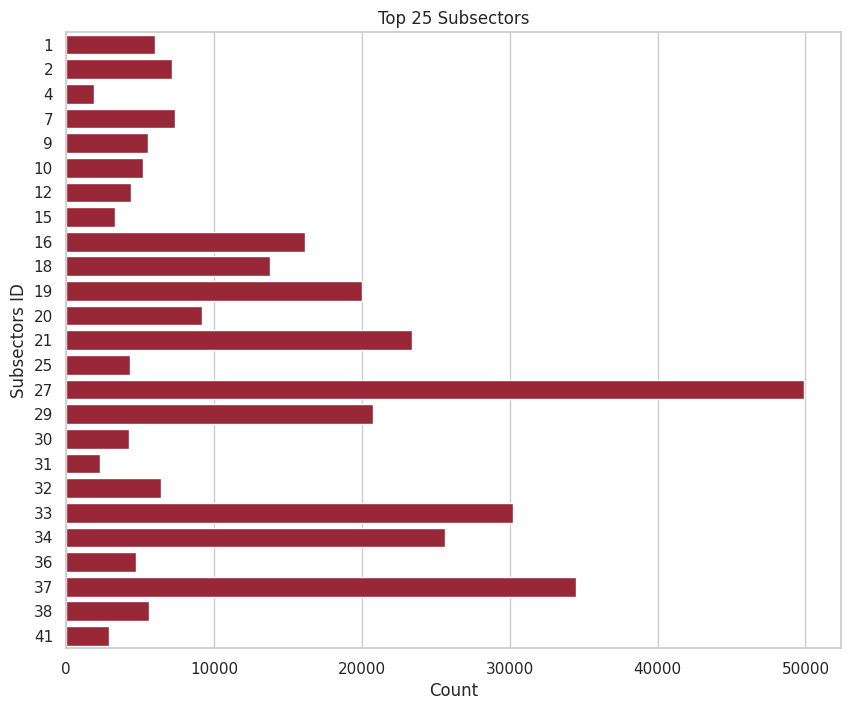

In [37]:
plt.figure(figsize=(10,8))
sns.barplot(data=Subsector_ID_Counts_sorted,x='count',y='subsector_id' ,orient='h')
plt.title('Top 25 Subsectors')
plt.xlabel('Count')
plt.ylabel('Subsectors ID')
plt.show()

# The histogram shows the distribution of counts across 25 categorical Subsector IDs. Key observations:

1- Subsector 27 has the highest count, exceeding 50,000, making it the most frequent category.

2- Subsectors 4, 15, 25, 31, and 41 have the lowest counts, each below 5,000.

3- Most subsectors (e.g., 1, 2, 7, 9, 10, 12, 16, 18, 20, 29, 32, 33, 36, 37) have counts between 5,000 and 20,000, indicating moderate frequency.

4- A few subsectors (e.g., 19, 29, 33) have higher counts, ranging between 30,000 and 40,000.

#What This Means:
1- Subsector #27 is likely a high-traffic  (e.g., supermarkets, gas stations).

2- Low-count subsectors may represent specialty stores (e.g. travel or services)

### <font color='blue'>Distribution of Category 1</b>

In [38]:
category_1_count = merchants['category_1'].value_counts().reset_index()
category_1_count

,category_1,count
0,N,317489
1,Y,6540


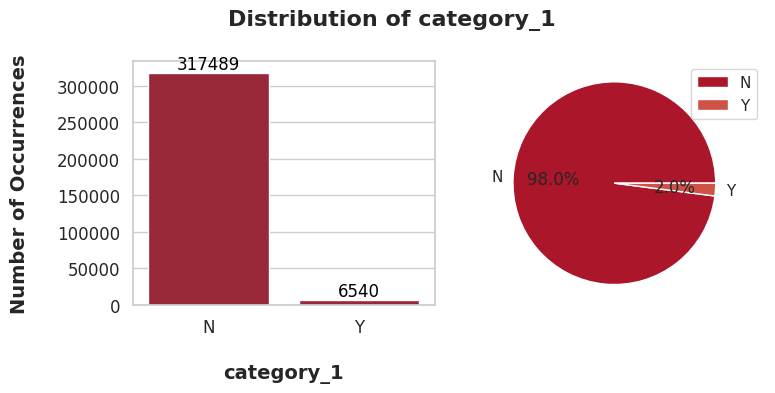

In [39]:
plot_categorical_feature(category_1_count)

#What the Data Shows:

1- 98% of merchants are labeled "N" (31.7M)

2- Only 2% are "Y" (65K), a tiny fraction

#What This Likely Means:

1- "N" = Standard merchants (most common type)

2- "Y" = Rare subset, possibly Special business types (e.g., luxury) orUnique payment methods (e.g., premium subscriptions)

### <font color='blue'>Distribution of Most Recent Sales Range</b>

In [40]:
most_recent_sales_range_count = merchants['most_recent_sales_range'].value_counts().reset_index()
most_recent_sales_range_count

,most_recent_sales_range,count
0,E,171030
1,D,115004
2,C,33358
3,B,3945
4,A,692


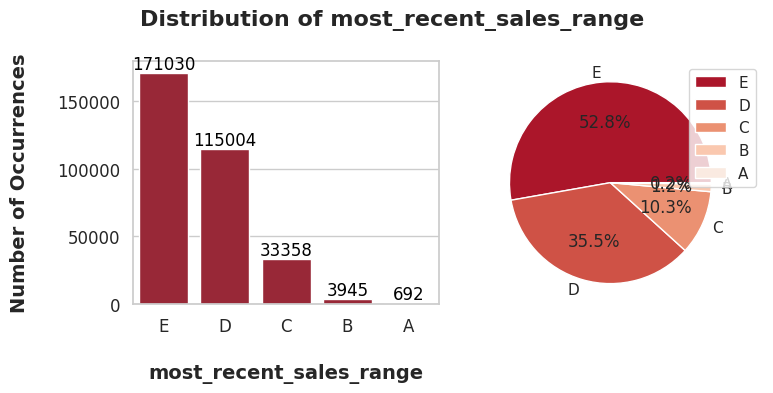

In [41]:
plot_categorical_feature(most_recent_sales_range_count)

#Key Findings:

1- Most merchants (88%) fall into the top two sales ranges (D & E):

      A- E (highest tier): 53% of merchants (171,000)

      B- D: 36% (115,000)

2- Lower tiers are rare:

      A- C: 10% (33,000)

      B- B: 1% (about 4,000)

      C- A (lowest): 0.2% (692 merchants)


# What This Means:

1- The dataset is dominated by high-performing merchants (likely top service providers).

2- Very few merchants have low recent sales—possibly new, or struggling businesses.

### <font color='blue'>Distribution of Most Recent Purchase Range</b>

In [42]:
most_recent_purchases_range_count = merchants['most_recent_purchases_range'].value_counts().reset_index()
most_recent_purchases_range_count

,most_recent_purchases_range,count
0,E,167949
1,D,117878
2,C,33324
3,B,4280
4,A,598


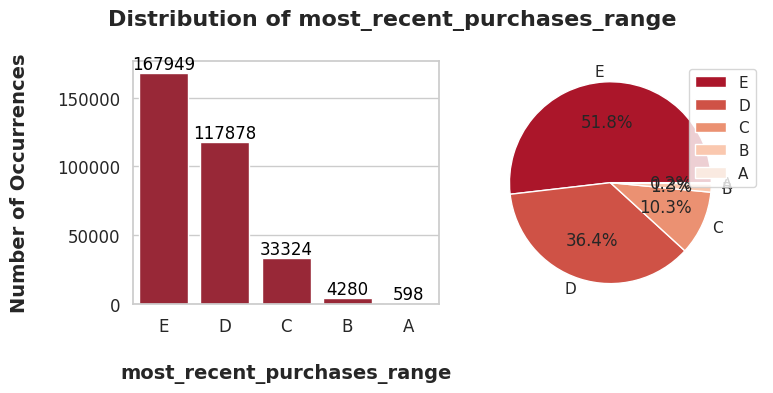

In [43]:
plot_categorical_feature(most_recent_purchases_range_count)

### <font color='blue'>Counts of Active Month Lag</b>

In [44]:
active_months_lag12_count = merchants['active_months_lag12'].value_counts().reset_index()
active_months_lag12_count

,active_months_lag12,count
0,12,296920
1,11,4017
2,10,3772
3,9,3485
4,8,3412
5,7,3008
6,6,2493
7,5,2096
8,4,1878
9,3,1544


<Figure size 800x400 with 0 Axes>

<Axes: xlabel='active_months_lag12', ylabel='Number of Occurrences'>

Text(0.5, 1.0, 'Counts of Active Month Lag')

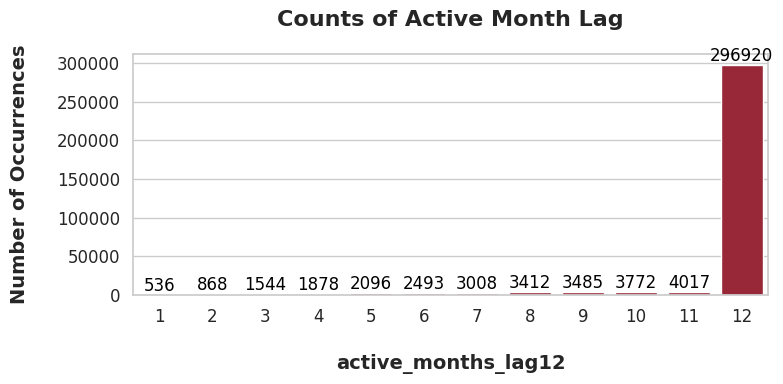

In [45]:
plt.figure(figsize=(8,4))
bar_plot(active_months_lag12_count,column='active_months_lag12',ax=plt.gca(),orient='v')
plt.title('Counts of Active Month Lag', weight = "bold", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

#What the Data Shows:
1- Most merchants (29,692) were active all 12 months—indicating stable, well-established businesses.

2- Fewer merchants were active for shorter periods:

3- Only 536 were active for just 1 month (likely new or struggling businesses).

4- Activity gradually increases toward 11 months (4,017 merchants).

#What This Means:
1- Customers mostly transact with reliable, year-round merchants—likely big retailers, or popular services.

2- Short-term active merchants (1-11 months) could represent:

      A- New businesses still gaining traction

      B- Seasonal stores (e.g., holiday shops)

      C- Businesses that closed or faced challenges

### <font color='blue'>Distribution of Category 4</b>

In [46]:
category_4_count = merchants['category_4'].value_counts().reset_index()
category_4_count

,category_4,count
0,N,231756
1,Y,92273


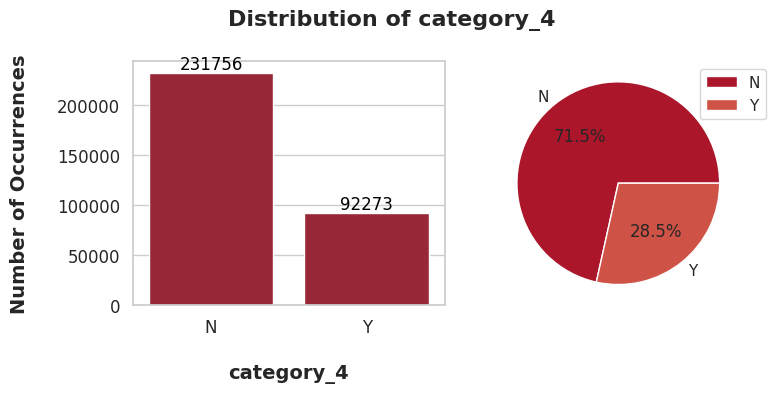

In [47]:
plot_categorical_feature(category_4_count)

#What the Data Shows:

1- 71.5% (231,756 merchants) → "N" (Majority)

2- 28.5% (92,273 merchants) → "Y" (Significant minority)

#What This Means:

1- "N" merchants represent the standard/mainstream businesses.

2- "Y" merchants (~1 in 4) likely have a Unique payment options (e.g., installments, digital wallets), Premium/luxury services or Membership-based models

### <font color='blue'>Distribution of Category 2</b>

In [48]:
category_2_count = merchants['category_2'].value_counts().reset_index()
category_2_count

,category_2,count
0,1.000,167278
1,5.000,51254
2,3.000,50177
3,4.000,35255
4,2.000,20065


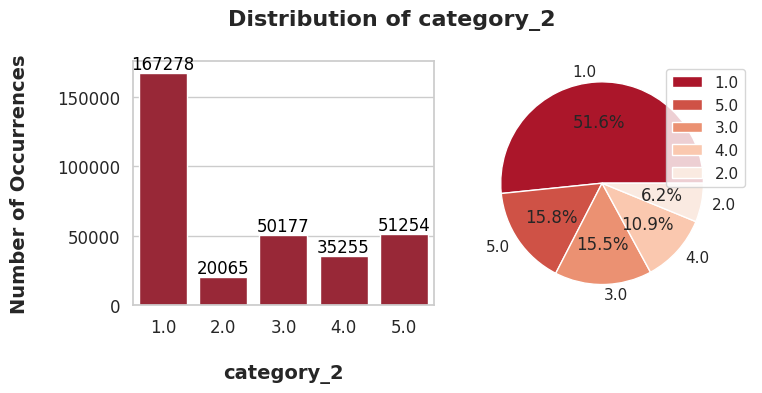

In [49]:
plot_categorical_feature(category_2_count)

#What the Data Shows:
1- 1.0 dominates: 51.6% of merchants (167K), major

2- 5.0: 15.8%

3- 3.0: 15.5%

4- 4.0: 10.9%

5- 2.0: lowest at 6.2%

#What This Means
1- Category 1.0 = The "standard" merchant type (likely mainstream retailers, common services).

2- Categories 2.0-5.0 = Smaller, specialized groups

### <font color='blue'>Distribution of Numerical 1</b>

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='numerical_1', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Numerical 1')

Text(0.5, 0, 'Numerical 1')

([<matplotlib.axis.XTick at 0x7f173e35f890>,
 [Text(-0.05, 0, '−0.050'),
  Text(-0.025, 0, '−0.025'),
  Text(0.0, 0, '0.000'),
  Text(0.02500000000000001, 0, '0.025'),
  Text(0.05, 0, '0.050'),
  Text(0.075, 0, '0.075'),
  Text(0.10000000000000002, 0, '0.100'),
  Text(0.125, 0, '0.125')])

(-0.05, 0.125)

(0.0, 50000.0)

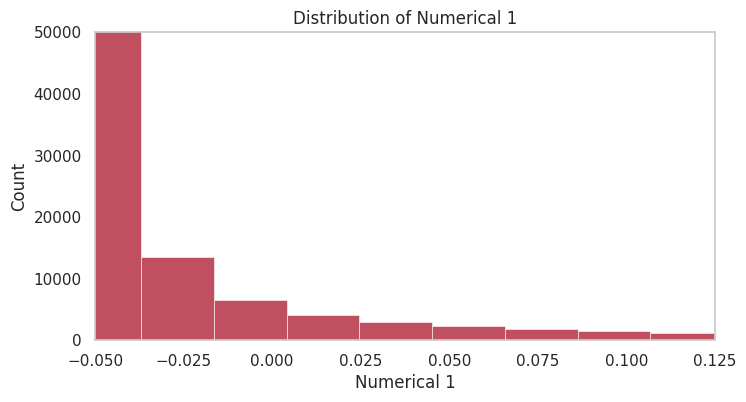

In [50]:
plt.figure(figsize=(8, 4))
sns.histplot(data=merchants,x='numerical_1',bins=100)
plt.title('Distribution of Numerical 1')
plt.xlabel('Numerical 1')
plt.xticks(np.arange(-0.05, 0.15, 0.025))
plt.xlim(-0.05, 0.125)
plt.ylim(0, 50000)
plt.grid(False)
plt.show()

#What This Means:
In the Elo Merchant Category Recommendation competition, numerical_1 is likely a continuous feature related to merchant performance or behavior (e.g., sales growth, transaction frequency, or a risk score). The heavy skewness suggests that most merchants have low values, possibly indicating stable or low-growth profiles, while a few with higher values might represent growing or high-performing merchants.

### <font color='blue'>Distribution of Average Purchase Lag 12</b>

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='avg_purchases_lag12', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Average Purchase Lag 12')

Text(0.5, 0, 'Average Purchase Lag 12')

(0.0, 5.0)

(0.0, 150000.0)

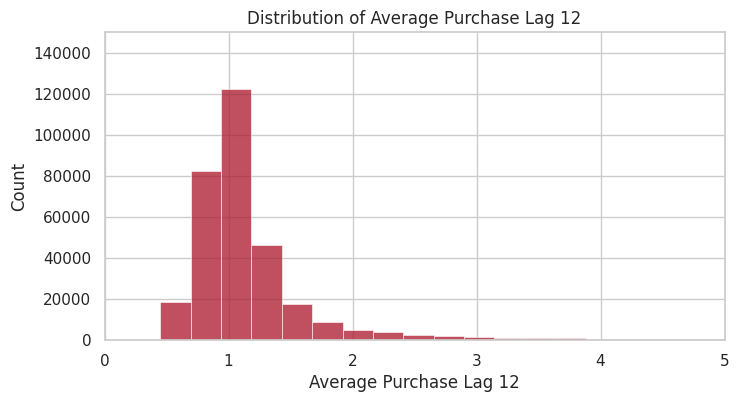

In [51]:
plt.figure(figsize=(8, 4))
sns.histplot(data=merchants,x='avg_purchases_lag12',bins=100)
plt.title('Distribution of Average Purchase Lag 12')
plt.xlabel('Average Purchase Lag 12')
plt.xlim(0, 5)
plt.ylim(0, 150000)
plt.show()

#Key Findings
1- Most merchants have low activity (~120,000 peak at ~1 purchase/month).

2- High-frequency merchants (2+ purchases/month) are rare (long tail up to 5).

#What This Means
1- Typical merchants see few transactions monthly—likely small/local businesses.

2- Rare high-frequency merchants (tail end) could be Popular chains (e.g., supermarkets, coffee shops), or Subscription-based services

#Why It Matters for Loyalty
1- Low-frequency merchants: May rely on occasional buyers → loyalty programs could boost repeat visits.

2- High-frequency merchants: study their customers for loyalty patterns.

# <font color='red'>5- ***Feature Encoding***</b>

In [52]:
# Encode categorical features to numerical

merchants['category_1'] = merchants['category_1'].map({'Y' : 1 , 'N' : 0})
merchants['category_4'] = merchants['category_4'].map({'Y' : 1 , 'N' : 0})

merchants['most_recent_sales_range'] = merchants['most_recent_sales_range'].map({'A': 1 , 'B': 2 , 'C': 3 , 'D': 4 , 'E': 5})
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range'].map({'A': 1 , 'B': 2 , 'C': 3 , 'D': 4 , 'E': 5})

# <font color='red'>6- ***Feature Engineering***</b>

In [53]:
# Create Aggregation dictionary to define how to aggregate columns

aggregation = {
    'subsector_id': ['nunique',statistics.mode],
    'numerical_1':['mean','max','min','sum',statistics.mode],
    'category_1':[statistics.mode,'mean','sum'],
    'most_recent_sales_range':[statistics.mode,'mean','sum'],
    'most_recent_purchases_range':[statistics.mode,'mean','sum'],
    'avg_sales_lag12':['mean','sum','max','min'],
    'avg_purchases_lag12':['mean','sum','max','min'],
    'active_months_lag12':['mean','sum','max','min'],
    'category_4':[statistics.mode,'mean','sum'],
    'state_id':[statistics.mode,'nunique'],
    'category_2':[statistics.mode,'mean','sum'],
}

In [54]:
# Group the 'merchants' by 'merchant_id' and apply the aggregations

aggregate_merchants = merchants.groupby('merchant_id').agg(aggregation)
aggregate_merchants.head(3)

subsector_id      numerical_1                              \
                     nunique mode        mean    max    min    sum   mode   
merchant_id                                                                 
M_ID_000025127f            1   37      -0.057 -0.057 -0.057 -0.057 -0.057   
M_ID_0000699140            1   27      -0.057 -0.057 -0.057 -0.057 -0.057   
M_ID_00006a5552            1   29      -0.057 -0.057 -0.057 -0.057 -0.057   

                category_1           most_recent_sales_range            \
                      mode  mean sum                    mode  mean sum   
merchant_id                                                              
M_ID_000025127f          0 0.000   0                       5 5.000   5   
M_ID_0000699140          0 0.000   0                       4 4.000   4   
M_ID_00006a5552          0 0.000   0                       5 5.000   5   

                most_recent_purchases_range           avg_sales_lag12        \
                                       mode  mean sum            mean   sum   
merchant_id                                                                   
M_ID_000025127f                           5 5.000   5           1.080 1.080   
M_ID_0000699140                           4 4.000   4           1.240 1.240   
M_ID_00006a5552                           5 5.000   5           1.220 1.220   

                            avg_purchases_lag12                    \
                  max   min                mean   sum   max   min   
merchant_id                                                         
M_ID_000025127f 1.080 1.080               2.090 2.090 2.090 2.090   
M_ID_0000699140 1.240 1.240               1.155 1.155 1.155 1.155   
M_ID_00006a5552 1.220 1.220               1.036 1.036 1.036 1.036   

                active_months_lag12             category_4           state_id  \
                               mean sum max min       mode  mean sum     mode   
merchant_id                                                                     
M_ID_000025127f              12.000  12  12  12          1 1.000   1        9   
M_ID_0000699140              12.000  12  12  12          0 0.000   0        9   
M_ID_00006a5552              12.000  12  12  12          0 0.000   0       15   

                        category_2              
                nunique       mode  mean   sum  
merchant_id                                     
M_ID_000025127f       1      1.000 1.000 1.000  
M_ID_0000699140       1      1.000 1.000 1.000  
M_ID_00006a5552       1      1.000 1.000 1.000

In [55]:
# Rename the columns of the 'aggregate_merchants' DataFrame

aggregate_merchants.columns = [str(uppers)+'_'+str(lowers).strip() for uppers,lowers in aggregate_merchants.columns.values]
aggregate_merchants  =aggregate_merchants.reset_index()
aggregate_merchants.head(3)

,merchant_id,subsector_id_nunique,subsector_id_mode,numerical_1_mean,numerical_1_max,numerical_1_min,numerical_1_sum,numerical_1_mode,category_1_mode,category_1_mean,category_1_sum,most_recent_sales_range_mode,most_recent_sales_range_mean,most_recent_sales_range_sum,most_recent_purchases_range_mode,most_recent_purchases_range_mean,most_recent_purchases_range_sum,avg_sales_lag12_mean,avg_sales_lag12_sum,avg_sales_lag12_max,avg_sales_lag12_min,avg_purchases_lag12_mean,avg_purchases_lag12_sum,avg_purchases_lag12_max,avg_purchases_lag12_min,active_months_lag12_mean,active_months_lag12_sum,active_months_lag12_max,active_months_lag12_min,category_4_mode,category_4_mean,category_4_sum,state_id_mode,state_id_nunique,category_2_mode,category_2_mean,category_2_sum
0,M_ID_000025127f,1,37,-0.057,-0.057,-0.057,-0.057,-0.057,0,0.000,0,5,5.000,5,5,5.000,5,1.080,1.080,1.080,1.080,2.090,2.090,2.090,2.090,12.000,12,12,12,1,1.000,1,9,1,1.000,1.000,1.000
1,M_ID_0000699140,1,27,-0.057,-0.057,-0.057,-0.057,-0.057,0,0.000,0,4,4.000,4,4,4.000,4,1.240,1.240,1.240,1.240,1.155,1.155,1.155,1.155,12.000,12,12,12,0,0.000,0,9,1,1.000,1.000,1.000
2,M_ID_00006a5552,1,29,-0.057,-0.057,-0.057,-0.057,-0.057,0,0.000,0,5,5.000,5,5,5.000,5,1.220,1.220,1.220,1.220,1.036,1.036,1.036,1.036,12.000,12,12,12,0,0.000,0,15,1,1.000,1.000,1.000


In [56]:
# Display the number of rows and columns of 'aggregate_merchants'

aggregate_merchants.shape

(324029, 37)

In [58]:
# Save the 'aggregate_merchants' DataFrame to CSV file without the Index

aggregate_merchants.to_csv('/content/drive/MyDrive/Final_Project_ELO_Merchant/aggregate_merchants.csv', index=False)

print("Aggregate Merchants Saved")

Aggregate Merchants Saved
